### 영화 정보 불러오기

In [2]:
import pandas as pd
# 영화 정보 로딩(10681)
# movieID와 제목만 사용
m_cols = ['movie_id', 'title', 'genre']
# dat 파일 형식이 어떤 건지 모르겠네(csv 같은 느낌인가?)
movies = pd.read_csv('data/ml-10m/movies.dat', names=m_cols, sep='::', encoding='latin-1', engine='python')  
# read movies.dat and adjust the cols name as m_cols. 

# genre를 list 형식으로 저장한다.
# 와 진심 처음 보는 형태의 코드...
movies['genre'] = movies.genre.apply(lambda x:x.split('|'))
print(movies.head())

   movie_id                               title  \
0         1                    Toy Story (1995)   
1         2                      Jumanji (1995)   
2         3             Grumpier Old Men (1995)   
3         4            Waiting to Exhale (1995)   
4         5  Father of the Bride Part II (1995)   

                                               genre  
0  [Adventure, Animation, Children, Comedy, Fantasy]  
1                     [Adventure, Children, Fantasy]  
2                                  [Comedy, Romance]  
3                           [Comedy, Drama, Romance]  
4                                           [Comedy]  


In [3]:
movies.shape

(10681, 3)

In [4]:
print('------------na check----------')
print(movies.isna().sum())
print('------------dtypes----------')
print(movies.dtypes)
print('------------genre----------')
print(movies['genre'].unique)

------------na check----------
movie_id    0
title       0
genre       0
dtype: int64
------------dtypes----------
movie_id     int64
title       object
genre       object
dtype: object
------------genre----------
<bound method Series.unique of 0        [Adventure, Animation, Children, Comedy, Fantasy]
1                           [Adventure, Children, Fantasy]
2                                        [Comedy, Romance]
3                                 [Comedy, Drama, Romance]
4                                                 [Comedy]
                               ...                        
10676                        [Adventure, Children, Comedy]
10677                              [Crime, Drama, Romance]
10678                                      [Comedy, Drama]
10679                                     [Drama, Romance]
10680                                             [Comedy]
Name: genre, Length: 10681, dtype: object>


### 태그 정보 불러오기

In [5]:
# 사용자가 부여한 영화의 태그 정보 로딩
t_cols = ['user_id', 'movie_id', 'tag', 'timestamp']
user_tagged_movies = pd.read_csv('data/ml-10m/tags.dat', names=t_cols, sep='::', engine='python')

# tag를 소문자로 바꾼다.
user_tagged_movies['tag'] = user_tagged_movies['tag'].str.lower()

user_tagged_movies.head

<bound method NDFrame.head of        user_id  movie_id              tag   timestamp
0           15      4973       excellent!  1215184630
1           20      1747         politics  1188263867
2           20      1747           satire  1188263867
3           20      2424  chick flick 212  1188263835
4           20      2424            hanks  1188263835
...        ...       ...              ...         ...
95575    71556      1377           gothic  1188263571
95576    71556      2424      chick flick  1188263606
95577    71556      3033           comedy  1188263626
95578    71556      3081           gothic  1188263565
95579    71556      7438          western  1188263589

[95580 rows x 4 columns]>

In [6]:
print(f'태그 종류={len(user_tagged_movies.tag.unique())}') # 태그 종류=15241
print(f'태그 레코드 수={len(user_tagged_movies)}') # 태그 레코드 수=95580
print(f'태그가 붙어 있는 영화 수={len(user_tagged_movies.movie_id.unique())}') # 태그가 붙어 있는 영화 수=7601

태그 종류=15241
태그 레코드 수=95580
태그가 붙어 있는 영화 수=7601


In [7]:
# tag를 영화별로 list 형식으로 저장한다.
movie_tags = user_tagged_movies.groupby('movie_id').agg({'tag':list})

# 태그 정보를 결합한다.
movies = movies.merge(movie_tags, on='movie_id', how='left')

movies.head()

,movie_id,title,genre,tag
0,1,Toy Story (1995),"[Adventure, Animation, Children, Comedy, Fantasy]","[pixar, pixar, pixar, animation, pixar, animat..."
1,2,Jumanji (1995),"[Adventure, Children, Fantasy]","[for children, game, animals, joe johnston, ro..."
2,3,Grumpier Old Men (1995),"[Comedy, Romance]","[funniest movies, comedinha de velhinhos engra..."
3,4,Waiting to Exhale (1995),"[Comedy, Drama, Romance]",[girl movie]
4,5,Father of the Bride Part II (1995),[Comedy],"[steve martin, pregnancy, remake, steve martin..."


### 평갓값 데이터

평갓값 데이터 수가 1,000만 건에 이르므로 데이터를 사용해 실험하면 알고리즘에 따라 결과를 얻기까지 며칠이 걸리기도 한다.  
평갓값은 0.5~5.0 사이 0.5 간격으로 표시된다.

In [8]:
# 평갓값 데이터 로딩(데이터양이 많으므로 환경에 따라 로딩에 시간이 걸린다.)
r_cols = ['user_id', 'movie_id', 'rating', 'timestamp']
ratings = pd.read_csv('data/ml-10m/ratings.dat', names=r_cols, sep='::', engine='python')
ratings.head()

,user_id,movie_id,rating,timestamp
0,1,122,5.0,838985046
1,1,185,5.0,838983525
2,1,231,5.0,838983392
3,1,292,5.0,838983421
4,1,316,5.0,838983392


따라서 실무에서는 데이터를 샘플링 해 작은 데이터셋으로 빠르게 실험을 반복하고 좋은 결과를 내는 알고리즘에 한해 데이터를 늘려 시험한다.

**사용자 수 1,000명의 평갓값 통계 정보**

In [9]:
# 데이터 양이 많으므로 사용자 수를 1000명으로 줄여 실험
valid_user_ids = sorted(ratings.user_id.unique())[:1000]
ratings = ratings[ratings["user_id"].isin(valid_user_ids)]

# 영화 데이터와 평가 데이터를 결합한다.
movielens = ratings.merge(movies, on="movie_id")
movielens.head()

,user_id,movie_id,rating,timestamp,title,genre,tag
0,1,122,5.0,838985046,Boomerang (1992),"[Comedy, Romance]","[dating, nudity (topless - brief), can't remem..."
1,1,185,5.0,838983525,"Net, The (1995)","[Action, Crime, Thriller]","[computers, computers, internet, irwin winkler..."
2,1,231,5.0,838983392,Dumb & Dumber (1994),[Comedy],"[jeff daniels, jim carrey, stupid, jim carrey,..."
3,1,292,5.0,838983421,Outbreak (1995),"[Action, Drama, Sci-Fi, Thriller]","[biology, gross, disease, futuristmovies.com, ..."
4,1,316,5.0,838983392,Stargate (1994),"[Action, Adventure, Sci-Fi]","[egypt, space, time travel, time travel, alien..."


In [10]:
import numpy as np
movielens.groupby('user_id').agg({'movie_id' : len}).agg({'movie_id':[min, max, np.mean, len]})

C:\Users\eunjo\AppData\Local\Temp\ipykernel_23484\500867367.py:2: FutureWarning: The provided callable <built-in function min> is currently using Series.min. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "min" instead.
  movielens.groupby('user_id').agg({'movie_id' : len}).agg({'movie_id':[min, max, np.mean, len]})
C:\Users\eunjo\AppData\Local\Temp\ipykernel_23484\500867367.py:2: FutureWarning: The provided callable <built-in function max> is currently using Series.max. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "max" instead.
  movielens.groupby('user_id').agg({'movie_id' : len}).agg({'movie_id':[min, max, np.mean, len]})
C:\Users\eunjo\AppData\Local\Temp\ipykernel_23484\500867367.py:2: FutureWarning: The provided callable <function mean at 0x000001C5E25956C0> is currently using Series.mean. In a future version of pandas, the provided callabl

,movie_id
min,20.00
max,1668.00
mean,132.83
len,1000.00


**평가된 영화에 대한 결과**

In [11]:
movielens.groupby('movie_id').agg({'user_id':len}).agg({'user_id':[min, max, np.mean, len]})

C:\Users\eunjo\AppData\Local\Temp\ipykernel_23484\2297131014.py:1: FutureWarning: The provided callable <built-in function min> is currently using Series.min. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "min" instead.
  movielens.groupby('movie_id').agg({'user_id':len}).agg({'user_id':[min, max, np.mean, len]})
C:\Users\eunjo\AppData\Local\Temp\ipykernel_23484\2297131014.py:1: FutureWarning: The provided callable <built-in function max> is currently using Series.max. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "max" instead.
  movielens.groupby('movie_id').agg({'user_id':len}).agg({'user_id':[min, max, np.mean, len]})
C:\Users\eunjo\AppData\Local\Temp\ipykernel_23484\2297131014.py:1: FutureWarning: The provided callable <function mean at 0x000001C5E25956C0> is currently using Series.mean. In a future version of pandas, the provided callable w

,user_id
min,1.000000
max,496.000000
mean,19.719418
len,6736.000000


평갓값 수=132830
        movie_id
rating          
0.5          851
1.0         4847
1.5         1247
2.0        10292
2.5         3729
3.0        31706
3.5         9661
4.0        39917
4.5         6949
5.0        23631


<Axes: xlabel='rating'>

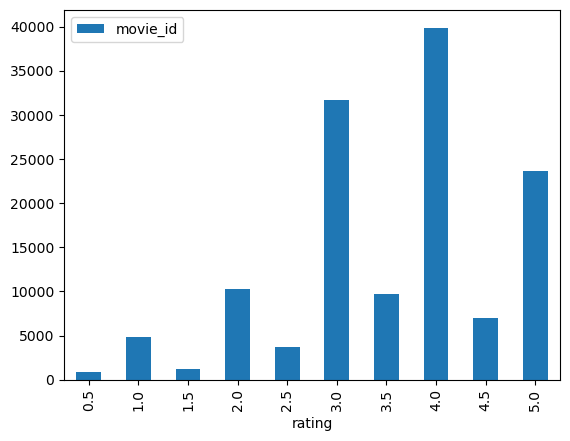

In [12]:
print(f'평갓값 수={len(movielens)}')
tmp = movielens.groupby('rating').agg({'movie_id':len})
print(tmp)
tmp.plot.bar()

### 평가 방법
MovieLens dataset에서 사용자는 적어도 20편 이상의 영화를 평가했음  
그래서 사용자가 최근 평가한 5개의 영화 평갓값: 테스트용 / 나머지: 학습용

In [19]:
# 학습용과 테스트용으로 데이터 분할
# 각 사용자가 가장 최근에 평가한 5건의 영화를 평가용으로 사용하고 그 외는 학습용으로 사용
# 먼저 각 사용자가 평가한 영화의 순서 계산
# 직전에 평가한 영화부터 순서를 부여해 나감

movielens['timestamp_rank'] = movielens.groupby('user_id')['timestamp'].rank(ascending=False, method='first')
movielens_train = movielens[movielens['timestamp_rank'] > 5]
movielens_test = movielens[movielens['timestamp_rank']<= 5]

In [21]:
# RMSE(Root Mean Squared Error)
from typing import List
from sklearn.metrics import mean_squared_error
def calc_rmse(self, true_rating: List[float],
              pred_rating: List[float]) -> float:
    return np.sqrt(mean_squared_error(true_rating, pred_rating))


In [22]:
# 순위지표 Precision@K , Recall@K

from typing import Dict

# recall@K를 계산하는 함수
def calc_recall_at_k(
    true_user2items: Dict[int, List[int]],
    pred_user2items: Dict[int, List[int]],
    k: int
) -> float:
    scores = []
    # 테스트 데이터에 존재하는 각 사용자의 recall@k를 계산
    for user_id in true_user2items.keys():
        # 각 유저의 실제 평가값과 예상 평가값, 그리고 k(예측 영화 개수)를 입력해 recall값을 구함
        r_at_k = _recall_at_k(true_user2items[user_id],
                              pred_user2items[user_id], k)
        # 각 유저에 대한 recall값을 scores에 추가
        scores.append(r_at_k)
    return np.mean(scores)

def _recall_at_k(self, true_items: List[int],
                 pred_items: List[int], k: int) -> float:
    if len(true_items) == 0 or k == 0:
        return 0.0
    
    # 사용자 선호 영화 중 사용자가 추천받은 영화의 비율
    r_at_k = (len(set(true_items) & set(pred_items[:k]))) / len(true_items)
    return r_at_k

def calc_precision_at_k(
    true_user2items: Dict[int, List[int]],
    pred_user2items: Dict[int, List[int]],
    k: int
) -> float:
    scores = []
    # 테스트 데이터에 존재하는 각 사용자의 precision@k를 계산
    for user_id in true_user2items.keys():
        p_at_k = _precision_at_k(true_user2items[user_id],
                                 pred_user2items[user_id], k)
        scores.append(p_at_k)
    return np.mean(scores)

def _precision_at_k(true_items: List[int],
                    pred_items: List[int], k: int) -> float:
    if k == 0:
        return 0.0
    p_at_k = (len(set(true_items) & set(pred_items[:k]))) / k
    return p_at_k

통일된 포맷 생성

In [ ]:
# 데이터 로딩과 평가 지표 계산 공통 모듈 로딩
from test_util.data_loader import DataLoader
from test_util.metric_calculator import MetricCalculator

# 1. MovieLens 데이터 로딩
data_loader = DataLoader(num_users=1000, num_test_items=5,
                         data_path='data/ml-10m/')
movielens = data_loader.load()

# 2. 각종 알고리즘 구현
recommender = ()# XXXRecommender()
recommend_result = recommender.recommend(movielens)

# 3. 평가 지표 계산
metric_calculator = MetricCalculator()
metrics = metric_calculator.calc(
    movielens.test.rating.tolist(), recommend_result.rating.tolist(),
    movielens.test_user2items, recommend_result.user2items, k=10
)
print(metrics)

각 파일 읽기와 학습용 데이터, 테스트용 데이터 분할 처리 등을 재사용하기 위해 DataLoader 클래스 내부에 정의한다.  
참고는 util/data_loader.py